In [1]:
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import ndimage
from skimage.data import astronaut, coffee, cat, rocket, binary_blobs, brain, clock

In [2]:
images = [astronaut(), coffee(), cat(), clock(), rocket()]

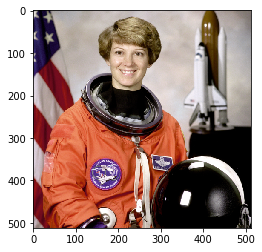

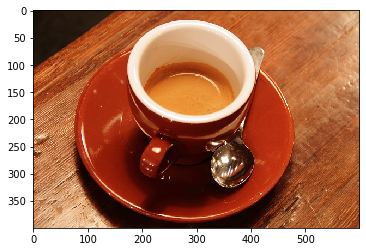

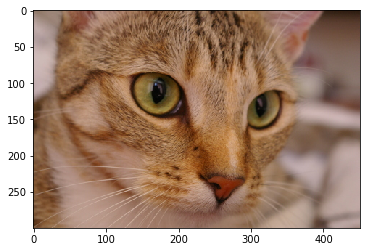

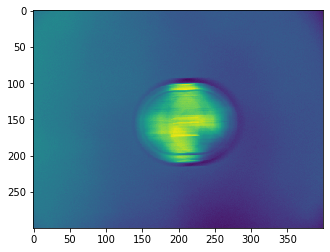

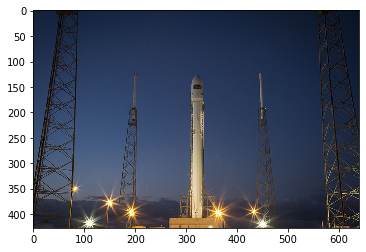

In [3]:
for img in images:
    plt.imshow(img)
    plt.show()

Papers:
* [Image Filtering Algorithms and Techniques: a review](https://www.researchgate.net/profile/Gaurav-Gupta-53/publication/325681876_Image_Filtering_Algorithms_and_Techniques_A_Review/links/5b1e1ab0aca272021cf585c9/Image-Filtering-Algorithms-and-Techniques-A-Review.pdf)

* [Analysis of color image filtering methods](https://www.researchgate.net/profile/Ziad-Alqadi/publication/319815286_Analysis_of_Color_Image_Filtering_Methods/links/59bcfa52aca272aff2d9d86b/Analysis-of-Color-Image-Filtering-Methods.pdf)

* [Digital Image Filtering Techniques- A survey](https://www.researchgate.net/publication/324985754_Digital_Image_Filtering_Techniques-_A_survey)

In [4]:
def add_salt_pepper(image, prob):
    """
    Add salt and pepper noise to a given image.
    
    Parameters
    ----------
    image : numpy.array
        Image to add noise to.
    prob: float
        Probability of the noise.
    
    References
    ----------
    Taken from:
    https://gist.github.com/lucaswiman/1e877a164a69f78694f845eab45c381a
    """
    output = image.copy()
    
    if len(image.shape) == 2:
        black = 0
        white = 255            
    else:
        colorspace = image.shape[2]
        if colorspace == 3:  # RGB
            black = np.array([0, 0, 0], dtype='uint8')
            white = np.array([255, 255, 255], dtype='uint8')
        else:  # RGBA
            black = np.array([0, 0, 0, 255], dtype='uint8')
            white = np.array([255, 255, 255, 255], dtype='uint8')
    
    probs = np.random.random(image.shape[:2])
    output[probs < (prob / 2)] = black
    output[probs > 1 - (prob / 2)] = white
    
    return output


def add_noise(img, mean=0, std=1, cast=True):
    """Add gaussian noise to a given image to create a noisy
    image.
    
    Parameters
    ----------
    img : numpy.array
        Image to add noise to.
    mean : int or float
        Mean of the gaussian noise.
    std : int or float
        Standard deviation of the gaussian noise.
    
    References
    ----------
    .. [1] StackOverflow - Why does adding Gaussian noise to image give white screen?
       https://stackoverflow.com/questions/50641860/why-does-adding-gaussian-noise-to-image-give-white-screen
    """
    noisy_img = np.clip(img + np.random.normal(mean, std, img.shape), 0, 255)
    
    if cast:
        noisy_img = noisy_img.astype('uint8') # cast to unsigned integer. See references
    
    return noisy_img

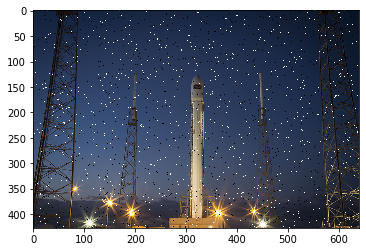

In [5]:
sp = add_salt_pepper(image=img, prob=0.02)
plt.imshow(sp)

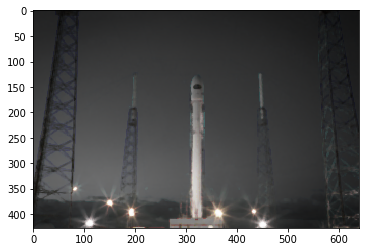

In [6]:
plt.imshow(ndimage.median_filter(sp, size=5))

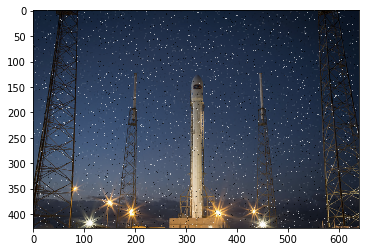

In [7]:
plt.imshow(ndimage.gaussian_filter(sp, 0.5))

In [8]:
# filters
# https://scikit-image.org/docs/dev/api/skimage.filters.html

# Morphologic operations
# https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html

In [9]:
from numba import jit

In [10]:
@jit(nopython=False)
def median_filter_numba(img,K_size=3):

    # Tamaño imagen 
    h,w,c = img.shape
    
    # Zero padding
    pad = K_size//2
    out = np.zeros((h + 2*pad,w + 2*pad,c),dtype=np.float)
    out[pad:pad+h,pad:pad+w] = img.copy().astype(np.float)
    
    # Proceso de filtrado
    tmp = out.copy()
    for y in range(h):
        for x in range(w):
            for ci in range(c):
                out[pad+y,pad+x,ci] = np.median(tmp[y:y+K_size,x:x+K_size,ci])
    
    out = out[pad:pad+h,pad:pad+w].astype(np.uint8)
    
    return out

In [29]:
def median_filter(img,K_size=3):

    # Tamaño imagen 
    h,w,c = img.shape
    
    # Zero padding
    pad = K_size//2
    out = np.zeros((h + 2*pad,w + 2*pad,c),dtype=np.float)
    out[pad:pad+h,pad:pad+w] = img.copy().astype(np.float)
    
    # Proceso de filtrado
    tmp = out.copy()
    for y in range(h):
        for x in range(w):
            for ci in range(c):
                out[pad+y,pad+x,ci] = np.median(tmp[y:y+K_size,x:x+K_size,ci])
    
    out = out[pad:pad+h,pad:pad+w].astype(np.uint8)
    
    return out

In [11]:
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

In [13]:
def get_rgb_channels(img):
    
    msg = 'Input must be RGB image'
    assert len(img.shape) == 3, msg
    
    red = img.copy()
    red[:, :, 1] = 0
    red[:, :, 2] = 0
    
    green = img.copy()
    green[:, :, 0] = 0
    green[:, :, 2] = 0
    
    blue = img.copy()
    blue[:, :, 0] = 0
    blue[:, :, 1] = 0
    
    return red, green, blue

In [14]:
from skimage.util import img_as_float, img_as_ubyte

In [23]:
def fourier_transform_denoising(img, n_components=1000):
    """
    Filters and image using the Fourier Transform
    
    References
    ----------
    .. [1] Apeer Micro - Tutorial 40 - What is Fourier transform 
       and how is it relevant for image processing?
       https://www.youtube.com/watch?v=RVE-CSZijAI&ab_channel=Apeer_micro
    
    .. [2] Apeer Micro - Tutorial 41 - mage filtering using Fourier
       transform in python
       https://www.youtube.com/watch?v=9mLeVn8xzMw&ab_channel=Apeer_micro
    """
    shape = img.shape
    red, green, blue = get_rgb_channels(img=img)
    
    channel_list = [red, green, blue]
    filtered_list = []
    
    # denoise, cast and clip
    for channel in channel_list:
        res = fft_denoiser(x=channel.ravel(), n_components=n_components, to_real=True)
        res = res.reshape(shape).astype('uint')
        res = np.clip(res, 0, 255)
        
        filtered_list.append(res)
    
    return sum(filtered_list)

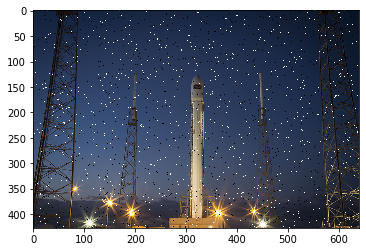

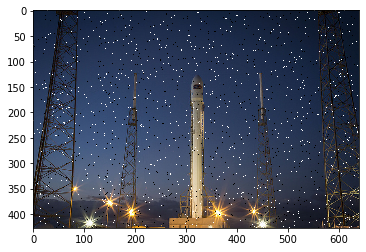

In [24]:
plt.imshow(sp)
plt.show()

plt.imshow(fourier_transform_denoising(img=sp, n_components=-10))

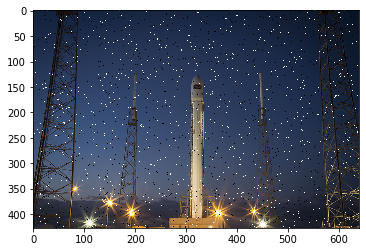

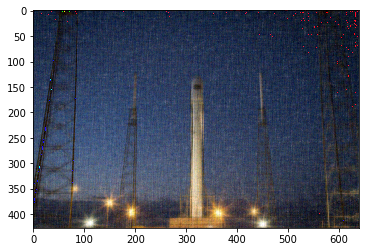

In [28]:
plt.imshow(sp)
plt.show()

plt.imshow(fourier_transform_denoising(img=sp, n_components=800))

In [32]:
%time _ = median_filter(sp)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


CPU times: user 29.9 s, sys: 256 ms, total: 30.2 s
Wall time: 30 s


In [33]:
%time _ = median_filter_numba(sp)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


CPU times: user 211 ms, sys: 2.06 ms, total: 213 ms
Wall time: 211 ms
